# Pathway Anti-correlation Analysis

Several previous appoaches have used transcriptomics for drug mechanism of action deconvolution and drug repositioning. [Iorio et al., (2010)](https://doi.org/10.1073/pnas.1000138107) and later [Emon et al., (2020)](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03568-5#ref-CR15) suggested using expert-curated pathway databases as a means of dimensionality reduction.

This notebook demonstrates re-implementing a similar workflow that relies on differential gene expression profiles curated in the [CREEDS database](https://maayanlab.cloud/CREEDS) based on drug perturbations, gene knockouts, gene overexpressions, and diseases.

Notably, it uses [PyBioPAX](https://github.com/indralab/pybiopax) to acquire and process [Reactome](https://reactome.org/) as an example pathway database.

This notebook was added in [indralab/pybiopax#21](https://github.com/indralab/pybiopax/pull/21).

In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import itertools as itt
from sklearn.feature_selection import VarianceThreshold
import pystow
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.auto import tqdm
import numpy as np
from indra.databases import hgnc_client
import logging
import mols2grid
from indra.statements import pretty_print_stmts
from functools import lru_cache
from scipy.stats import pearsonr
from pyobo.sources import reactome
import pubchempy as pcp
import time
from rdkit import Chem
import sys
from indra.sources import indra_db_rest

In [2]:
logging.getLogger("indra_db_rest.request_logs").setLevel(logging.WARNING)
logging.getLogger("indra_db_rest.query_processor").setLevel(logging.WARNING)

In [3]:
print(sys.version)

3.9.5 (default, May  4 2021, 03:36:27) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [4]:
time.asctime()

'Mon Dec  6 12:25:03 2021'

In [5]:
CREEDS = pystow.module("bio", "creeds")
CHEMICAL = CREEDS.join(name="chemical.tsv")
DISEASE = CREEDS.join(name="disease.tsv")
GENE = CREEDS.join(name="gene.tsv")

## Load Data

The analysis itself has been carried out by running `python -m pybiopax.analysis.creeds_analysis` which stores the results in a consistent location using [`pystow`](https://github.com/cthoyt/pystow). This code automatically acquires all data dependencies and should be runnable on any system.

In [6]:
gene_df = pd.read_csv(GENE, sep="\t")
gene_df.head()

perturbation                 pathway             p             q        mlq
0    hgnc:3791   reactome:R-HSA-392499  3.563415e-74  9.072454e-71  70.042275
1    hgnc:3791  reactome:R-HSA-8953854  8.163782e-67  6.928330e-64  63.159371
2    hgnc:3791  reactome:R-HSA-8953897  7.054626e-67  6.928330e-64  63.159371
3    hgnc:3791  reactome:R-HSA-2262752  1.441503e-66  9.175168e-64  63.037386
4    hgnc:3791  reactome:R-HSA-5663205  3.018265e-53  1.536900e-50  49.813354

In [7]:
chemical_df = pd.read_csv(CHEMICAL, sep="\t")
chemical_df.head()

perturbation                 pathway              p  \
0  pubchem.compound:445154   reactome:R-HSA-168256  1.345600e-164   
1  pubchem.compound:445154  reactome:R-HSA-1430728  5.476500e-158   
2  pubchem.compound:445154   reactome:R-HSA-392499  6.337993e-129   
3  pubchem.compound:445154  reactome:R-HSA-8953897  5.270683e-116   
4  pubchem.compound:445154  reactome:R-HSA-1643685  2.402538e-115   

               q         mlq  
0  3.425898e-161  160.465226  
1  6.971584e-155  154.156669  
2  5.378843e-126  125.269311  
3  3.354790e-113  112.474335  
4  1.223372e-112  111.912441

In [8]:
disease_df = pd.read_csv(DISEASE, sep="\t")
disease_df.head()

perturbation                 pathway              p              q  \
0  doid:DOID:12930  reactome:R-HSA-1430728  7.155170e-132  1.821706e-128   
1  doid:DOID:12930  reactome:R-HSA-8953897   2.820769e-79   3.590839e-76   
2  doid:DOID:12930  reactome:R-HSA-2262752   1.730824e-75   1.468893e-72   
3  doid:DOID:12930   reactome:R-HSA-156842   1.658557e-71   1.055672e-68   
4  doid:DOID:12930   reactome:R-HSA-392499   4.061869e-71   2.068304e-68   

          mlq  
0  127.739522  
1   75.444804  
2   71.833010  
3   67.976471  
4   67.684386

## Pathway Size Filter

Pathways that are either too big or too small don't give very useful <i>p</i>-values in the hypergeometric test, so they are filtered out.

In [9]:
participants_df = reactome.ensure_participant_df(version="78")
participants_df.columns = ["uniprot_id", "reactome_id"]
idx = participants_df.groupby("reactome_id").count()["uniprot_id"]

# Make a list of pathways that are neither too big nor small
valid_size = {f"reactome:{k}" for k, v in ((5 < idx) & (idx < 250)).items() if v}

In [10]:
gene_df = gene_df[gene_df["pathway"].isin(valid_size)]
chemical_df = chemical_df[chemical_df["pathway"].isin(valid_size)]
disease_df = disease_df[disease_df["pathway"].isin(valid_size)]

## Feature Preprocessing

Right now we're going to use a min-max normalized version of the minus-log-<i>p</i>-value as the feature for each gene-pathway and chemical-pathway pair.

In [11]:
def minmax(x):
    return (x - x.min()) / (x.max() - x.min())


gene_df["feature"] = minmax(-np.log10(gene_df["p"]))
chemical_df["feature"] = minmax(-np.log10(chemical_df["p"]))
disease_df["feature"] = minmax(-np.log10(disease_df["p"]))

# Dataframe Reshaping


In [12]:
gene_square_df = gene_df.pivot(index="perturbation", columns="pathway")["feature"]
gene_square_df.shape

(466, 1794)

In [13]:
chem_square_df = chemical_df.pivot(index="perturbation", columns="pathway")["feature"]
chem_square_df.shape

(148, 1794)

In [14]:
disease_square_df = disease_df.pivot(index="perturbation", columns="pathway")["feature"]
disease_square_df.shape

(178, 1794)

## Investigate the Variance of features in both datasets

Even after min-max normalization, some pathways have very little variance, and are therefore should be excluded. The following histograms show the variances over all features in each of the pairs of entities' associated datasets.

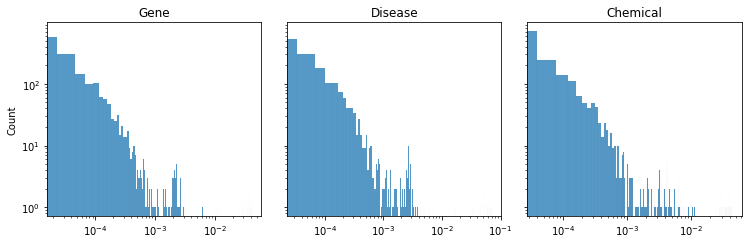

In [15]:
fig, (lax, miax, rax) = plt.subplots(1, 3, figsize=(10.5, 3.5), sharey=True)

sns.histplot(gene_square_df.var().values, ax=lax)
lax.set_yscale("log")
lax.set_xscale("log")
lax.set_title("Gene")

sns.histplot(disease_square_df.var().values, ax=miax)
miax.set_yscale("log")
miax.set_xscale("log")
miax.set_title("Disease")

sns.histplot(chem_square_df.var().values, ax=rax)
rax.set_yscale("log")
rax.set_xscale("log")
rax.set_title("Chemical")

plt.tight_layout()
plt.show()

In [16]:
MIN_VAR = 2.5e-3

var_series = (
    (MIN_VAR < gene_square_df.var())
    & (MIN_VAR < chem_square_df.var())
    & (MIN_VAR < disease_square_df.var())
)
var_idx = [k for k, v in var_series.items() if v]
print(f"keeping {var_series.sum()} features with more than {MIN_VAR} in both datasets")

chem_square_df = chem_square_df[var_idx]
gene_square_df = gene_square_df[var_idx]
disease_square_df = disease_square_df[var_idx]

keeping 62 features with more than 0.0025 in both datasets


In [17]:
# Check comparisons are going to make sense
(chem_square_df.columns == gene_square_df.columns).all()

True

In [18]:
(disease_square_df.columns == gene_square_df.columns).all()

True

## Make Comparison

After slightly engineering the pathway features associate with each entity, the pairwise Pearson correlation coefficients are calculated. A histogram is shown for the distribution of correlation coefficients.

In [19]:
def comp(df1, df2):
    # Do all by all comparison
    rows = [
        [pearsonr(df1_values, df2_values)[0] for _, df2_values in df2.iterrows()]
        for _, df1_values in tqdm(df1.iterrows(), total=len(df1))
    ]
    return pd.DataFrame(rows, index=df1.index, columns=df2.index)


chem_gene_df = comp(chem_square_df, gene_square_df)
chem_dis_df = comp(chem_square_df, disease_square_df)
gene_dis_df = comp(gene_square_df, disease_square_df)

  0%|          | 0/148 [00:00<?, ?it/s]

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

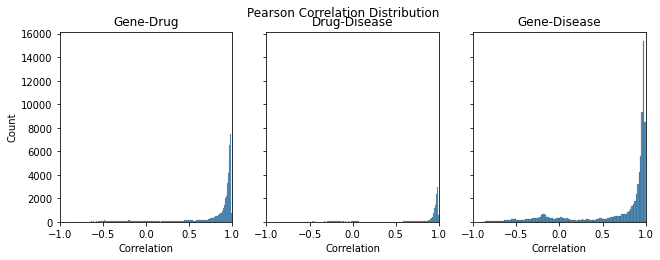

In [20]:
fig, (lax, miax, rax) = plt.subplots(1, 3, figsize=(10.5, 3.5), sharey=True)

sns.histplot(chem_gene_df.values.ravel(), ax=lax)
lax.set_title("Gene-Drug")
lax.set_xlabel("Correlation")
lax.set_xlim([-1, 1])

sns.histplot(chem_dis_df.values.ravel(), ax=miax)
miax.set_title("Drug-Disease")
miax.set_xlabel("Correlation")
miax.set_xlim([-1, 1])

sns.histplot(gene_dis_df.values.ravel(), ax=rax)
rax.set_title("Gene-Disease")
rax.set_xlabel("Correlation")
rax.set_xlim([-1, 1])

plt.suptitle("Pearson Correlation Distribution")
plt.show()

For the rest of the notebook, we'll focus on chemical-gene pairs (e.g., for mechanism of action deconvolution). The same sort of analysis could be done on chemical-disease (e.g., for drug repositioning) or gene-disease (e.g., for target prioritization) pairs as well.

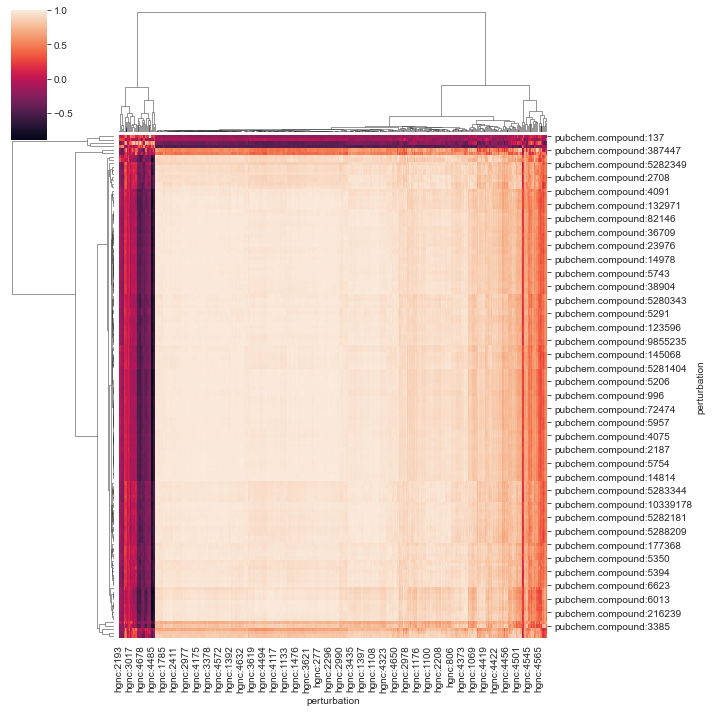

In [21]:
sns.set_style("white")
g = sns.clustermap(chem_gene_df.fillna(0.0))
# g.savefig("/Users/cthoyt/Desktop/creeds.png")

## Look at Negative correlations

There seem to be a high number of positive correlations, so untangling those would probably be more difficult than examining the smaller number of negative correlations. After a bit of trial and error, -0.70 was chosen as a maximum correlation value cutoff and a relatively small number of chemical-gene pairs were kept.

In [22]:
cutoff = -0.70
negative_corr_df = chem_gene_df.melt(ignore_index=False)
negative_corr_df.index.name = "chemical"
negative_corr_df = negative_corr_df.reset_index()
negative_corr_df.columns = ["chemical", "gene", "correlation"]
negative_corr_df = negative_corr_df[negative_corr_df["correlation"] < cutoff]
negative_corr_df["cid"] = negative_corr_df["chemical"].map(
    lambda x: x.removeprefix("pubchem.compound:")
)
negative_corr_df

chemical       gene  correlation       cid
15014      pubchem.compound:3989  hgnc:2389    -0.707018      3989
15029    pubchem.compound:446220  hgnc:2389    -0.719202    446220
15071      pubchem.compound:6013  hgnc:2389    -0.704175      6013
30641  pubchem.compound:10852289  hgnc:3236    -0.711710  10852289
30654    pubchem.compound:148177  hgnc:3236    -0.746279    148177
...                          ...        ...          ...       ...
51647   pubchem.compound:9855235  hgnc:4485    -0.805095   9855235
51648   pubchem.compound:9919910  hgnc:4485    -0.782534   9919910
51649   pubchem.compound:9933475  hgnc:4485    -0.800233   9933475
51650       pubchem.compound:996  hgnc:4485    -0.864994       996
51651   pubchem.compound:9962735  hgnc:4485    -0.857000   9962735

[273 rows x 4 columns]

It turns out that there are a relatively small number of genes represented in this set.

In [23]:
negative_corr_df.gene.unique()

array(['hgnc:2389', 'hgnc:3236', 'hgnc:4267', 'hgnc:4296', 'hgnc:4485'],
      dtype=object)

In [24]:
negative_corr_df.chemical.nunique()

129

Interestingly, there were two genes that were consistently the most negatively correlated with chemicals' effects:

- [GPER1 (hgnc:4485)](https://bioregistry.io/hgnc:4485) - G protein-coupled estrogen receptor 1
- [GLA (hgnc:4296)](https://bioregistry.io/hgnc:4296) - galactosidase alpha

Below, we'll look into the structures of the chemicals to see if there are any patterns:

In [25]:
@lru_cache
def get_pubchem(cid):
    return pcp.Compound.from_cid(cid)

In [27]:
compounds = {cid: get_pubchem(cid) for cid in tqdm(negative_corr_df.cid.unique())}
smiles = {cid: compound.isomeric_smiles for cid, compound in compounds.items()}
negative_corr_df["SMILES"] = negative_corr_df["cid"].map(smiles)

  0%|          | 0/129 [00:00<?, ?it/s]

GPER1 Affectors

In [28]:
mols2grid.display(
    negative_corr_df[negative_corr_df.gene == "hgnc:4485"],
    smiles_col="SMILES",
    fixedBondLength=25,
    subset=["img", "cid"],
)

GLA Affectors

In [29]:
mols2grid.display(
    negative_corr_df[negative_corr_df.gene == "hgnc:4296"],
    smiles_col="SMILES",
    fixedBondLength=25,
    subset=["img", "cid"],
)

While it wasn't so easy to pick patterns out directly, we will consider an alternative approach using knowledge-based priors from INDRA below.

In [30]:
@lru_cache(maxsize=None)
def get_statements(pubchem_id, hgnc_id):
    return indra_db_rest.get_statements(
        subject=f"{pubchem_id}@PUBCHEM",
        object=f"{hgnc_id}@HGNC",
    )

In [31]:
it = sorted(set(map(tuple, negative_corr_df[["chemical", "gene"]].values)))

rv = {}
for chemical_curie, gene_curie in tqdm(it, desc="Getting explanations", unit="pair"):
    pubchem_id = chemical_curie.removeprefix("pubchem.compound:")
    hgnc_id = gene_curie.removeprefix("hgnc:")
    rv[pubchem_id, hgnc_id] = get_statements(pubchem_id, hgnc_id)

  0%|          | 0/273 [00:00<?, ?it/s]

## Identifying High-Confidence Predictions with INDRA

Until now, all of the highly anti-correlated chemical-drug pairs can be considered as hypothesis mechanisms of action. In the next section, we query the INDRA database for prior knowledge explanations of these correlations. Pairs with both experimental and prior knowledge evidence can be considered high confidence, while experimental results without prior knowledge evidence can be considered as high potential (albeit low confidence) predictions that could/should be followed by additional triage and laboratory experimentation.

In [45]:
rows = []
for (pubchem_id, hgnc_id), processor in rv.items():
    if not processor.statements:
        continue
    c = get_pubchem(pubchem_id)
    rows.append(
        (
            pubchem_id,
            list(c.synonyms)[0] if c.synonyms else c.iupac_name,
            hgnc_id,
            hgnc_client.get_hgnc_name(hgnc_id),
            len(processor.statements),
        )
    )

explained_df = pd.DataFrame(
    rows,
    columns=[
        "pubchem_id",
        "pubchem_name",
        "gene_id",
        "gene_symbol",
        "statements",
    ],
).sort_values("statements", ascending=False)
explained_df

pubchem_id                                       pubchem_name gene_id  \
38       6623                                        Bisphenol A    4485   
31       5757                                          estradiol    4485   
8     2733526                                          tamoxifen    4485   
12       3385                                     5-Fluorouracil    3236   
33       6013                                       testosterone    3236   
23    5280343                                          quercetin    4485   
5       23973                                          7440-43-9    4485   
1       15625                2,3,7,8-TETRACHLORODIBENZO-P-DIOXIN    4296   
29       5743                                      dexamethasone    4296   
17     446220                                            cocaine    2389   
24    5280453                                         calcitriol    4296   
36       6037  (2S)-2-[[4-[(2-amino-4-oxo-1H-pteridin-6-yl)me...    3236   
37       6623                                        Bisphenol A    4296   
39        702                                            ethanol    4296   
34       6013                                       testosterone    4267   
25    5288209                                        FENRETINIDE    4296   
35       6013                                       testosterone    4296   
32       6013                                       testosterone    2389   
30       5743                                      dexamethasone    4485   
28    5354495                                          7440-36-0    4296   
27       5350                                       sulforaphane    4485   
40      77999                                      rosiglitazone    4485   
26       5350                                       sulforaphane    4296   
41        935                                          7440-02-0    4485   
0      145068                                       nitric oxide    4485   
21       4943                                           propofol    3236   
22    5280343                                          quercetin    4296   
10       3136                                               dmnq    4485   
2       15625                2,3,7,8-TETRACHLORODIBENZO-P-DIOXIN    4485   
3       23931                                          7439-97-6    4296   
4       23931                                          7439-97-6    4485   
6       23976                                          7440-47-3    4296   
7       23976                                          7440-47-3    4485   
9        3136                                               dmnq    4296   
11      31703                                        doxorubicin    4296   
20     451668                                         Decitabine    4485   
13     444795                                      Retinoic acid    4485   
14     444899                                   arachidonic acid    4296   
15     445154                                        resveratrol    4296   
16     445154                                        resveratrol    4485   
18     446220                                            cocaine    3236   
19     446220                                            cocaine    4485   
42        996                                             phenol    3236   

   gene_symbol  statements  
38       GPER1           9  
31       GPER1           7  
8        GPER1           6  
12        EGFR           5  
33        EGFR           5  
23       GPER1           4  
5        GPER1           4  
1          GLA           2  
29         GLA           2  
17       CRYAB           2  
24         GLA           2  
36        EGFR           2  
37         GLA           2  
39         GLA           2  
34        GHSR           1  
25         GLA           1  
35         GLA           1  
32       CRYAB           1  
30       GPER1           1  
28         GLA           1  
27       GPER1           1  
40       GPER1      

Several chemicals were prioritized with GPER1, denoting that these molecules could be modulators. While it's possible to inspect the table and conclude that estradiol is obviously a ligand for an estradiol receptor, the power in this method is that it uses INDRA's knowledgebase to automate that interpretation step, which makes this part of the analysis scalable to far more experiments than the small set present in CREEDS.

In [53]:
stmts = rv[counter.most_common(1)[0][0]].statements
for stmt in stmts:
    stmt.evidence[:] = [ev for ev in stmt.evidence if ev.text]

pretty_print_stmts(stmts, width=80)

[LIST INDEX: 0] Complex(bisphenol A(), GPER1())
EV INDEX: 0       It is important to note that BPA also binds the membrane
SOURCE: sparser   estrogen receptor GPR30 ( xref ; xref ), but the role of this
PMID: 23339879    receptor in DSA performance is currently not known.
--------------------------------------------------------------------------------
EV INDEX: 1       Using adisplacement assay based on plasma membranes prepared
SOURCE: sparser   from HEK293 cells transfected with zebrafish GPER, Fitzgerald
PMID: 29790728    et al. ( xref ) found that BPA bound to zebrafish GPER with an
                  RBA of 15.8% and that tetrabromobisphenol A and
                  tetrachlorobisphenol A showed effective binding at a single
                  tested concentration ().
--------------------------------------------------------------------------------
EV INDEX: 2       Some evidence suggests that BPA also binds to GPR30 and
SOURCE: sparser   mediates Erk activation [ xref , xref ].
PMID: